# Imports

In [1]:
import pandas as pd; import seaborn as sb; import statsmodels.formula.api as smf; import pingouin;
from itertools import combinations; import os; from analysis_helpers import *; 
import scipy; from scipy import stats; import os; import math; import warnings
warnings.filterwarnings('ignore')

# Load and organize data

In [2]:
gaze  = pd.read_csv('../parsed_data/full_gaze.csv')
behav = pd.read_csv('../parsed_data/full_behavioral.csv')

In [3]:
# put data into centimeters
gaze['av_x_coord'] = gaze['av_x_coord']*(59.8/2048)
gaze['av_y_coord'] = gaze['av_y_coord']*(33.6/1152)

# eliminate off-screen datapoints
gaze = gaze[(gaze['av_x_coord']   < 59.8) 
                                  & (gaze['av_y_coord'] < 33.6)
                                  & (gaze['av_x_coord'] > 0)
                                  & (gaze['av_y_coord'] > 0)]

In [4]:
count_data = gaze.groupby(['UniqueID','Run','Trial'], as_index=False).count()
count_data[count_data['avg']<5]

,UniqueID,Run,Trial,Unnamed: 0,Unnamed: 0.1,avg,fix,lefteye,raw,righteye,...,timestamp,xRaw_righteye,yRaw_righteye,xRaw_lefteye,yRaw_lefteye,av_x_coord,av_y_coord,Subject,Group,Experiment
467,5,7,7.0,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1623,20,4,6.0,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1651,20,7,7.0,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1653,20,7,9.0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2130,26,7,6.0,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2131,26,7,7.0,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
2868,37,5,5.0,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4832,63,7,8.0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6004,79,0,0.0,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
6005,79,0,1.0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


# Tendency to gaze towards cued side

In [5]:
# group gaze data by subject, run, and trial
gaze_grp = gaze.groupby(['UniqueID','Run','Trial'], as_index=False).mean()

# add av x coord to each presentation trial in behavioral df

for s in gaze_grp['UniqueID'].unique():  
# for each unique subject
    
    for r in gaze_grp[gaze_grp['UniqueID']==s]['Run'].unique():
    # for each run of that subject 
    
        for t in gaze_grp[(gaze_grp['UniqueID']==s) & (gaze_grp['Run']==r)]['Trial'].unique():
        # for each memory trial in that run
        
            if gaze_grp[(gaze_grp['UniqueID']==s) & (gaze_grp['Run']==r) & (gaze_grp['Trial']==t)].shape[0]>0:
            # if there are more than zero gazepoints recorded for that presentation trial
                
                # find the subject, run, and trial in the behavioral dataframe
                # then add the average gaze from that presentation trial in gaze df to the behavioral df
                
                # NOTE: in behavioral df, you have to specify 'Trial Type'=='Presentation' to assign gaze data
                # in gaaze df, there is no 'Trial Type' designation, because it is all from Presentation trials
                behav.loc[(behav['UniqueID']==s) 
                             & (behav['Run']==r) 
                             & (behav['Trial']==t)
                             & (behav['Trial Type']=='Presentation'), 'av_x_coord'] =  gaze_grp[(gaze_grp['UniqueID']==s) 
                                                                                        & (gaze_grp['Run']==r) 
                                                                                        & (gaze_grp['Trial']==t)]['av_x_coord'].item()
                
# make behav df gaze_from_center column (av_x_coord - screen_center) 
behav['gaze_from_center'] = behav['av_x_coord'] - 59.8/2

# make the behav df gaze_towards_cued_side column
# switch the signs of values for left-facing arrows
behav['gaze_towards_cued_side'] = behav['gaze_from_center']
behav.loc[(behav['Cued Side']=='<'),'gaze_towards_cued_side'] = -behav.loc[(behav['Cued Side']=='<')]['gaze_towards_cued_side']

# behav now has av x coord, gaze from center, and gaze towards cued side for each presentation trial
# these are mean values over all gazepoints in that prresentation trial


In [33]:
# for each experiment
for exp in ['/sustain','/variabl']:
    
    # conduct a a ttest - compare gaze towards cued side with hypothetical zero drift
    
    # select data from given experiment, Presentation trials only
    behav_1 = behav[(behav['Experiment']==exp) & (behav['Trial Type']=='Presentation')]
    
    # group the selected data by participant 
    behav_grp = behav_1.groupby(['UniqueID'], as_index=False).mean()
    
    print(exp)
    # conduct t-test relative to zero drift
    print(scipy.stats.ttest_1samp(behav_grp['gaze_towards_cued_side'],0))
    
    # calculate cohen's d?
    #print(np.mean(behav_grp['gaze_towards_cued_side'])/np.std(behav_grp['gaze_towards_cued_side']))
    print()

/sustain
Ttest_1sampResult(statistic=3.6110305466537524, pvalue=0.0006306585053386894)

/variabl
Ttest_1sampResult(statistic=2.8645929302250357, pvalue=0.006009788669403545)



In [8]:
# Ultimately want df with UniqueID, Run#, Pres Trial #, Attn Level, Av_x_coord, and Rating

# Data Restricted to Gaze Between Participants

In [9]:
# compute av x gaze's difference from screen center
# for every time point / gazepoint collected in each trial
# gaze['gaze_from_center'] = gaze['av_x_coord'] - 59.8/2

In [10]:
# gaze[abs(gaze['gaze_from_center'])>=4.2752]

In [11]:
# make gaze df gaze_from_center column (av_x_coord - screen_center) 
gaze['gaze_from_center'] = gaze['av_x_coord'] - 59.8/2

# select gazepoints where abs value of gaze deviation is more than 4.2752 
gaze_elims    = gaze[abs(gaze['gaze_from_center'])>=4.2752]

# group the subselected data by paticipant, run, and trial 
# this will be a list of subject, sun, and trials to exclude
grouped_elims = gaze_elims.groupby(['UniqueID','Run','Trial'], as_index=False).mean()

In [12]:
# behav[(behav['UniqueID']==s) & (behav['Run']==r) & (behav['Trial']==t) &
#                                    (behav['Trial Type']=='Presentation')]

In [13]:
# use the participant, run, and trial info in grouped_elims to  
# exclude trials from behav where gaze deviates too far left or right

# make empty list to store indices of trials we will eliminate
indices = []

# for every subject in grouped_elims
for s in grouped_elims['UniqueID'].unique():
    
    # for each run of that subejct in grouped_elims
    for r in grouped_elims[grouped_elims['UniqueID']==s]['Run'].unique():
        
        # for each presentation trial in that run where subs deviate more than specified distance
        for t in grouped_elims[(grouped_elims['UniqueID']==s) & (grouped_elims['Run']==r)]['Trial'].unique():
            
            # get the index of that PRESENTATION trial in the behavioral dataframe
            # append to the indices list
            indices.append(behav[(behav['UniqueID']==s) & (behav['Run']==r) & (behav['Trial']==t)
                                   & (behav['Trial Type']=='Presentation')].index.item())

now, we have a list of indices for memory trials testing memory for images that were presented when participant gaze deviated too far left or right


In [14]:
# make behav df without the trials in the exclusion index list
behav_restricted = behav.loc[~behav.index.isin(indices)]

In [15]:
# behav restricted now contains :

#   + PRES trials where subs did not gaze outside bounds
#   + all MEM trials

# behav_restricted[(behav_restricted['UniqueID']==0) & (behav_restricted['Run']==3)]

# Plot gaze data
####  Start with full gaze data

In [16]:
# make empty gaze dictionary 
gaze_added_mem_dict = {}

# for each experiment
for exp in ['/sustain','/variabl']:
    
    # make empty gaze list
    gaze_added_mem = []
    
    # select the data for that experiment
    data = behav[behav['Experiment']==exp]

    # for each unique participant
    for s in data['UniqueID'].unique():
        print(s)
        
        # for each run in that participant
        for r in data['Run'].unique():
            
            # add gaze data from each presentation trial to the corresponding memory trial
            gaze_added_mem.append(add_gaze(data[(data['UniqueID']==s) & (data['Run']==r)]))

    # concatenate into a Dataframe
    gaze_mem = pd.concat(gaze_added_mem)
    
    # add zero average x coord for novel images
    gaze_mem.loc[gaze_mem['Attention Level']=='Novel','av_x_coord']=0

    # set gaze_towards as distance from the center of the screen
    gaze_mem['gaze_towards'] = gaze_mem['av_x_coord'] - (59.8/2)

    # reverse the sign of gaze_towards for all images that were presented on the left of the screen ####
    # Attention category and cue indicate which side an image was on 
        # e.g. if the trial is cue-left, a person can only have Fully attended an image presented on the left
   
    # reverse sign of gaze_towards for cue_left images that were:
    # (Cue: LEFT)  AND  ( Attn Level : Full OR Attn Level: Side)
    gaze_mem.loc[(gaze_mem['Cued Side']=='<') 
                 & (gaze_mem['Attention Level'].isin(['Full', 'Side'])), 'gaze_towards'] = -gaze_mem[(gaze_mem['Cued Side']=='<') 
                                                                                                          & (gaze_mem['Attention Level'].isin(['Full', 'Side']))]['gaze_towards']
    # (Cue: RIGHT)  AND  ( Attn Level : None OR Attn Level: Category)
    gaze_mem.loc[(gaze_mem['Cued Side']=='>') 
                 & (gaze_mem['Attention Level'].isin(['None', 'Category'])), 'gaze_towards'] = -gaze_mem[(gaze_mem['Cued Side']=='>') & (gaze_mem['Attention Level'].isin(['None', 'Category']))]['gaze_towards']

    # group data by by participant, attention level, familiarity rating, experiment, trial type
    gaze_mem_grp = gaze_mem.groupby(['UniqueID','Attention Level', 'Familiarity Rating','Experiment','Trial Type'], as_index=False).mean()

    # add the grouped data to a dictionary key named for that experiment
    gaze_added_mem_dict[exp] = gaze_mem

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


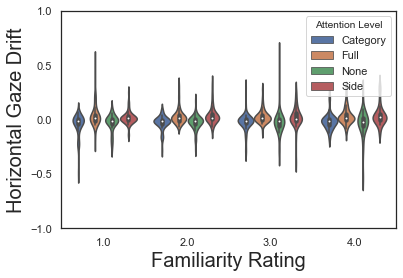

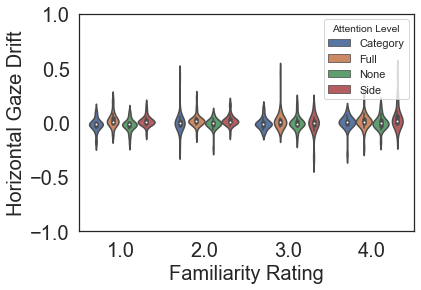

In [17]:
%matplotlib inline
gaze_mem_grp = 0

# for each experiment
for exp in ['/sustain','/variabl']:
    
    # group the data for that experiment by UniqueID, Attention Level, Familiarity Rating, Trial Type
    gaze_mem_grp = gaze_added_mem_dict[exp].groupby(['UniqueID','Attention Level', 'Familiarity Rating','Trial Type'], as_index=False).mean()

    # make scaled_gaze_towards by...
    
    # dividing gaze_towards by half of the screen width   
    # yielding the proportional distance gazepoint is towards nearest Right/Left edge of the screen
    # (e.g. did they look "all the way" over to the Right/Left? ..."half of the way over"?)
    gaze_mem_grp['scaled_gaze_towards'] = gaze_mem_grp['gaze_towards']/(59.8/2)

    # make plots in the 'white' style
    sb.set_style('white')

    # plot scaled_gaze_towards (y axis) in terms of Attention Level (x-axis) and 
    # Familiarity Rating (grouping)
    f = sb.violinplot(x='Familiarity Rating', y='scaled_gaze_towards', 
                  data=gaze_mem_grp[(gaze_mem_grp['Attention Level']!='Novel')&
                                   (gaze_mem_grp['Trial Type']=='Memory')], hue='Attention Level')
    
    # plot settings
    plt.grid(False)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.xlabel('Familiarity Rating',    fontsize = 20)
    plt.ylabel('Horizontal Gaze Drift', fontsize = 20)
    f.set(ylim=(-1, 1))
    plt.show()

#### then try with restricted data

In [18]:
gaze_added_mem_dict['/sustain']['gaze_towards']

0        -1.150009
1        -0.340017
2        -0.447489
3        -0.159331
4         0.305673
           ...    
23995    -2.734372
23996     0.442776
23997   -29.900000
23998   -29.900000
23999   -29.900000
Name: gaze_towards, Length: 24000, dtype: float64

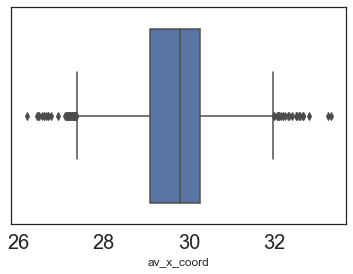

In [19]:
sb.boxplot(data = behav_restricted, x = 'av_x_coord')

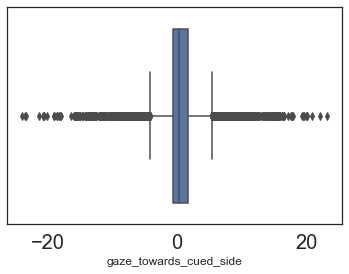

In [20]:
sb.boxplot(data = behav, x = 'gaze_towards_cued_side')

In [21]:
gaze_added_mem_dict = {}
gaze_added_mem = []

for exp in ['/sustain','/variabl']:
    
    data = behav_restricted[behav_restricted['Experiment']==exp]

    for s in data['UniqueID'].unique():
        print(s)
        for r in data['Run'].unique():
            gaze_added_mem.append(add_gaze(data[(data['UniqueID']==s) & (data['Run']==r)]))

    gaze_mem = pd.concat(gaze_added_mem)
    gaze_mem.loc[gaze_mem['Attention Level']=='Novel','av_x_coord']=0

    gaze_mem['gaze_towards'] = gaze_mem['av_x_coord'] - (59.8/2)

    gaze_mem.loc[(gaze_mem['Cued Side']=='<') 
                 & (gaze_mem['Attention Level'].isin(['Full', 'Side'])), 'gaze_towards'] = -gaze_mem[(gaze_mem['Cued Side']=='<') 
                                                                                                          & (gaze_mem['Attention Level'].isin(['Full', 'Side']))]['gaze_towards']

    gaze_mem.loc[(gaze_mem['Cued Side']=='>') 
                 & (gaze_mem['Attention Level'].isin(['None', 'Category'])), 'gaze_towards'] = -gaze_mem[(gaze_mem['Cued Side']=='>') & (gaze_mem['Attention Level'].isin(['None', 'Category']))]['gaze_towards']

    gaze_mem_grp = gaze_mem.groupby(['UniqueID','Attention Level', 'Familiarity Rating','Trial Type'], as_index=False).mean()

    gaze_added_mem_dict[exp] = gaze_mem

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


In [22]:
gaze_added_mem_dict['/sustain']['UniqueID'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [23]:
gaze_added_mem_dict['/sustain'].groupby(['UniqueID','Run','Trial'], as_index=False).mean()

,UniqueID,Run,Trial,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Subject,Attention Reaction Time (s),Familiarity Reaction Time (s),Familiarity Rating,...,Pre Invalid Cue,Attention Button,Rating History,Stimulus Onset,Stimulus End,Group,av_x_coord,gaze_from_center,gaze_towards_cued_side,gaze_towards
0,0,0,0.0,80,80,10,10,NaN,1.786,1.0,...,NaN,NaN,NaN,1.538591e+09,1.538591e+09,1,0.000000,NaN,NaN,-29.900000
1,0,0,1.0,81,81,11,10,NaN,1.171,3.0,...,NaN,NaN,NaN,1.538591e+09,1.538591e+09,1,NaN,NaN,NaN,NaN
2,0,0,2.0,82,82,12,10,NaN,1.670,1.0,...,NaN,NaN,NaN,1.538591e+09,1.538591e+09,1,0.000000,NaN,NaN,-29.900000
3,0,0,3.0,83,83,13,10,NaN,1.337,2.0,...,NaN,NaN,NaN,1.538591e+09,1.538591e+09,1,NaN,NaN,NaN,NaN
4,0,0,4.0,84,84,14,10,NaN,0.000,NaN,...,NaN,NaN,NaN,1.538591e+09,1.538591e+09,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,59,7,35.0,11995,285,395,9,NaN,1.624,3.0,...,NaN,NaN,NaN,1.571074e+09,1.571074e+09,2,NaN,NaN,NaN,NaN
19196,59,7,36.0,11996,286,396,9,NaN,0.000,NaN,...,NaN,NaN,NaN,1.571074e+09,1.571074e+09,2,30.342776,NaN,NaN,0.442776
19197,59,7,37.0,11997,287,397,9,NaN,1.572,2.0,...,NaN,NaN,NaN,1.571074e+09,1.571074e+09,2,0.000000,NaN,NaN,-29.900000
19198,59,7,38.0,11998,288,398,9,NaN,0.000,NaN,...,NaN,NaN,NaN,1.571074e+09,1.571074e+09,2,0.000000,NaN,NaN,-29.900000


In [24]:
gaze_added_mem_dict['/variabl'].head(n=3)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,...,Stimulus End,Attention Probe,Trial,UniqueID,Group,Experiment,av_x_coord,gaze_from_center,gaze_towards_cued_side,gaze_towards
4,4,4,154,10,Presentation,3,00937960627fa_sunaqsolmfydodnakub.jpg,00788941205fa_sunagountlxpzkytsmp.jpg,00937960627fa.jpg,sunaqsolmfydodnakub.jpg,...,1.538592e+09,x,4.0,0,1,/sustain,30.205673,0.305673,-0.305673,0.305673
160,160,160,160,10,Memory,3,NaN,NaN,NaN,NaN,...,1.538593e+09,NaN,0.0,0,1,/sustain,NaN,NaN,NaN,NaN
161,161,161,161,10,Memory,3,NaN,NaN,NaN,NaN,...,1.538593e+09,NaN,1.0,0,1,/sustain,0.000000,NaN,NaN,-29.900000


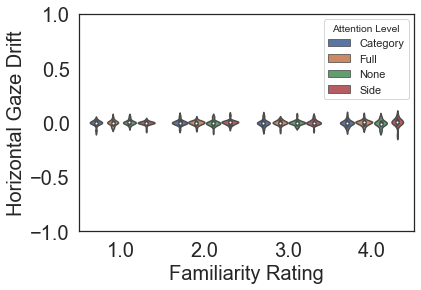

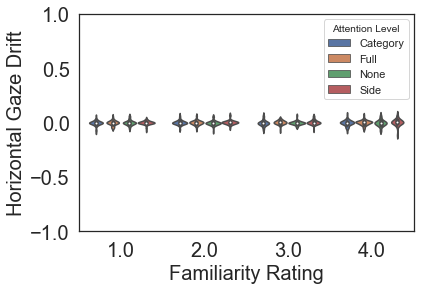

In [25]:
%matplotlib inline
for exp in ['/sustain','/variabl']:
    
    gaze_mem_grp = gaze_added_mem_dict[exp].groupby(['UniqueID','Attention Level', 'Familiarity Rating','Trial Type'], as_index=False).mean()

    # scale by screen size
    gaze_mem_grp['scaled_gaze_towards'] = gaze_mem_grp['gaze_towards']/(59.8/2)

    # plot
    sb.set_style('white')

    f = sb.violinplot(x='Familiarity Rating', y='scaled_gaze_towards', 
                  data=gaze_mem_grp[gaze_mem_grp['Attention Level']!='Novel'], hue='Attention Level')

    plt.grid(False)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.xlabel('Familiarity Rating',    fontsize = 20)
    plt.ylabel('Horizontal Gaze Drift', fontsize = 20)
    f.set(ylim=(-1, 1))
    plt.show()

In [26]:
behav_restricted.to_csv('../parsed_data/behav_restricted.csv')

# Show similar results in gaze restricted data as in full dataset

### Attended Category versus Unattended

In [42]:
# group data by UniqueID, Experiment, and Attention Level
d = behav_restricted.groupby(['UniqueID', 'Experiment', 'Attention Level'], as_index=False).mean()

# for each experiment
for experiment in ['/sustain', '/variabl']:
        
    # make empty lists Cats and Nones
    Cats  = []
    Nones = []
    
    # for each participant in the select experiment
    for s in d[(d['Experiment']==experiment)]['UniqueID'].unique():
        
        # obtain the average familiarity rating this participant gave to images attended at the Category level
        # append to the list Cats
        Cats.append(d[(d['UniqueID']==s) & (d['Attention Level'].isin(['Category']) & (d['Experiment']==experiment))]['Familiarity Rating'].mean())
        
        # obtain the average familiarity rating this participant gave to images attended at the None level
        # append to the list Nones
        Nones.append(d[(d['UniqueID']==s) & (d['Attention Level']=='None') & (d['Experiment']==experiment)]['Familiarity Rating'].mean())


    print('experiment : '+experiment)
    
    # conduct a paired t-test
    print(scipy.stats.ttest_rel(Cats, Nones))
    
    #print(cohen_d(Cats, Nones))
    print()

experiment : /sustain
Ttest_relResult(statistic=7.169020123474894, pvalue=1.399590794698868e-09)

experiment : /variabl
Ttest_relResult(statistic=0.4310799396268719, pvalue=0.6681920627291599)



### Attended Side versus Unattended

In [43]:
# group data by UniqueID, Experiment, and Attention Level
d = behav_restricted.groupby(['UniqueID', 'Experiment', 'Attention Level'], as_index=False).mean()

# for each experiment
for experiment in ['/sustain', '/variabl']:
    
    # make empty lists Sides and Nones
    Sides  = []
    Nones = []
    
    # for each participant in the select experiment
    for s in d[(d['Experiment']==experiment)]['UniqueID'].unique():

        # obtain the average familiarity rating this participant gave to images attended at the Side level
        # append to the list Sides
        Sides.append(d[(d['UniqueID']==s) & (d['Attention Level'].isin(['Side'])) & (d['Experiment']==experiment)]['Familiarity Rating'].mean())
        
        # obtain the average familiarity rating this participant gave to images attended at the None level
        # append to the list Nones
        Nones.append(d[(d['UniqueID']==s) & (d['Attention Level']=='None') & (d['Experiment']==experiment)]['Familiarity Rating'].mean())

    # conduct a paired t-test
    print(scipy.stats.ttest_rel(Sides, Nones))
    print()

Ttest_relResult(statistic=4.320885072719229, pvalue=6.048927164309282e-05)

Ttest_relResult(statistic=2.5918457744677217, pvalue=0.012363373090488588)



In [27]:
######################################################